In [1]:
# import packages
import pandas as pd
from decimal import Decimal

import numpy as np
import numpy.random as npr
from numpy.random import seed
from numpy.random import randint
from numpy import mean

from scipy.stats import norm
from scipy.integrate import quad 

import matplotlib.pyplot as plt
import bqplot.pyplot as bqplt
import ipywidgets as widgets
from ipywidgets import VBox, HBox, FloatSlider, Text, IntSlider, Layout
from bqplot import OrdinalScale, LinearScale, Bars, Lines, Axis, Hist, Figure
from IPython.display import display, HTML

Define currencies
$ \def\euro{\unicode{x20AC}} $
$ \def\yen{\unicode{x00A5}}  $
$ \def\pound{\unicode{x00A3}} $
$ \def\dollar{\unicode{x024}} $

# The Black-Scholes-Merton (BSM) model 
[Louis Bachelier](https://en.wikipedia.org/wiki/Louis_Bachelier) published the first known mathematically rigorous option valuation model in 1900. His work was less groundbreaking than one would assume. Especially since Bachelier developped the first mathematical model of [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion#History) in his paper. This random process is named after botanist [Robert Brown](https://en.wikipedia.org/wiki/Robert_Brown_(botanist,_born_1773) who described how grains of pollen of the plant Clarkia pulchella suspend in water under a microscope. [Thorvald Thiele](https://en.wikipedia.org/wiki/Thorvald_N._Thiele) independently described the process 20 years prior to Bachelier's work in statistical applications. [Albert Einstein](https://en.wikipedia.org/wiki/%C3%9Cber_die_von_der_molekularkinetischen_Theorie_der_W%C3%A4rme_geforderte_Bewegung_von_in_ruhenden_Fl%C3%BCssigkeiten_suspendierten_Teilchen) brought the solution of the problem to the attention of physicists and mainstream academia in 1905. [Jean Baptiste Perrin](https://en.wikipedia.org/wiki/Jean_Baptiste_Perrin) received his Nobel Price for Physics for work based on the foundations of Brownian motion. 

The main innovation of the BSM model is essentially the <mark>no-arbitrage</mark> approach, applied to a continuous time process. However, before explaining the model, it is useful to explain general concepts to build on the intuition behind the more complex BSM model. 

# Arbitrage free valuation  
Arbitrage free valution is an approach to security valuation that determines security values that are consistent with the absence of arbitrage opportunities.   
An <mark>arbitrage opportunity</mark> is a transaction that earns  
- without any net investment of money
- riskless profit    
 
<div class="alert alert-block alert-info">
<b>Tip: </b>   
That's why you can think of it as "free money". However, there is not a one-to-one correspondence between arbitrage and great investment opportunities. An arbitrage is certainly a great investment opportunity but a great investment opportunity need not be arbitrage. For example, investing $\dollar$1 for a chance to get either nothing for a 1% chance or $\dollar$1 Milllion for a 99% chance is definitely a great investment opportunity but it does not fulfill any of the two requirements for arbitrage. 
</div>

<div class="alert alert-block alert-warning"> 
<b>Fundamental Rules for an arbitrageur:</b>    
Rule #1: Do not use your own money   
Rule #2: Do not take any price risk
</div>   

An arbitrageur frequently needs to borrow money to satisfy Rule #1. This also means the arbitrageur does not spend the proceeds from short selling but invest them at the risk free interest rate. Rule #2 is concerned only with market price risk in a simplified context. Meaning liquidity risk, counterparty risk, aspects like [centralized clearing](https://en.wikipedia.org/wiki/Central_counterparty_clearing) or daily [mark-to-market](https://www.investopedia.com/terms/m/marktomarket.asp) are not covered and beyond the scope of this section. Transcation costs are also neglected for simplicity without loss of generality. If transcation costs exist, you will have a price band within which there is no arbitrage and not as single no arbitrage price. 


The underlying idea is that you cannot create money today with no risk or future liability. This approach is built on the <mark> law of one price</mark>, which states that if two investments have the same or equivalent future cashflows, then these two investments should have the same price because they are perfect substitutes for each other. A simple thought expirement explains why this should hold. If the law of one price is violated, someone could buy the cheaper asset and sell the more expensive, resulting in a gain at no risk, and with no commitment of capital. Furthermore, this action drives down the price of the expensive asset (which is sold) and increases the price of the cheaer asset (which is bought). Therefore, the price will eventually converge and no arbitrage will be reinstated. Note that this does not require for all market players to have perfect knowledge. It is suffcient that the size of the transactions moves the market. Since an arbitrageur gains riskless profit with this transaction, a single individual is basically enough as the transaction can be repeated over and over again until the arbirtage opportunity disappears.  

The law of one price is built on the <mark> value additivity</mark> principle, which states that the value of a portfolio is simply the sum of the values of each instrument held in the portfolio. Assume there are two assets. Asset A is a risk free zero coupon bond paying $\dollar$100 in one year and is prices at 95.2381 ($\dollar$100/1.05). Asset B is a portfolio of 105 units of asset A. Thereofore, it will pay $100*105 = 10500$ in one year. If asset b is priced today at 9500, an astute investor will release that $10500/1.05 = 10000 > 9500$. Therefore, the portfolio does not equal its parts and buying asset B is cheaper than buying 105 units of asset A. An arbitrageur would sell 105 units of asset A for a price of 95.2381 each and buy asset B for 9500, generating a risk free profit of 500 today ($95.2381*105 = 10000$) and net $\dollar$0 in one year from today because cash inlfow for asset B matches cash outflow for the 105 units of asset A sold.   

A second principle is <mark> dominance</mark>. Any financial asset with a riskfree profit in the future must have a positive price today. Therefore, the price of any 2 risk-free securities with the same timing and payoffs must be the same. If not, there will be a dominant trading strategy that costs the same as the other one, but which is always guaranteed to out-perform it.   

The result is that arbitrage opportunities are transitory. Prices will adjust until there are no arbitrage opportunities.    
<div class="alert alert-block alert-info">
<b>Tip: Implication for Fixed Income securities</b>   
Any Fixed Income security can be thought of as a portfolio of zero coupon bonds. A 5 year 2% Treasury issue is for example a package of eleven zero-coupon instruments (10 semiannual coupon payments and one pricipal value payment at maturity). Dealers are able to seperate the cashflows into zero coupon securities via a process called <mark>[stripping](https://www.investopedia.com/terms/c/coupon-stripping.asp)</mark>. These instruments are called <mark>[STRIPS](https://www.investopedia.com/terms/t/treasurystrips.asp)</mark> (an acronym for Separate Trading of Registered Interest and Principal of Securities). The opposite process is called <mark>reconstitution</mark>. Arbitrage profits are possible when the value additivity principle does not hold. 
</div>    


### Binomial model   

The [Cox Ross Rubinstein method](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.540.933&rep=rep1&type=pdf) (named after the authors John Cox, Stephen Ross and Mark Rubunstein in 1979) is the canonical model for pricing options using a binomial method.   

The option payoff can be replicated with a <mark>dynamic portfolio</mark> of the underlying instrument and financing. A dynamic portfolio is one whose composition changes over time. The <mark> multiperiod binomial model</mark> is a natural transition to the BSM option valuation model because the BSM model is equivalent to a binomial model in which the length of the time step essentially approaches zero. 

The binomial option pricing model can also be used to model <mark>path-dependent</mark> options, which are options whose values depend not only on the value of the underlying at expiration but also how it got there. The classic BSM model is only modelling <mark>[European options](https://en.wikipedia.org/wiki/Option_style)</mark>, which are <mark>path-independent</mark>. A European option can only be exercised at expiration. In contrast, an <mark> American Option</mark> can be exercised prior to expiration. The intermediate between a European optionand an American option is called a <mark> Bermudan</mark> option. The name is jocular: Bermuda, a British overseas territory, is somewhat American and somewhat European—in terms of both option style and physical location—but is nearer to American in terms of both. 

<div class="alert alert-block alert-info">
<b>Tip:</b> 
The continuous time process of the BSM model is consistent with a binomial model. This is because of the basic statistical fact that the binomial process with a "large" number of steps converges to the standard normal distribution. The section about the multi-period binomial model below explains this in some detail.     
</div>    

Let's introduce some notation:   
- $S_t$ denotes the underlying instrument's price at time t, where t is expresed as a fraction of a year: e.g. 90 days with ACT/365 would be $90/365 = 0.2466 = t$
- $S_T$ price of the underlying observed at expiration 
- $c_t$ European style call price at time t
- $C_t$ American style call price at time t  
- $X$ denotes the exercise price (also called [strike](https://www.investopedia.com/terms/e/exerciseprice.asp) price)   
<div class="alert alert-block alert-success">
<b>Tip:</b> In formulas, the exercise price is often denoted by X, and the notation for the strike price is usually K. This choice probably owes its origin to a 19th-century Baseball reporter who simply ran out of letters [Henry Chadwick](https://www.britannica.com/story/why-does-k-stand-for-a-strikeout-in-baseball). Traders frequenty say the option is struck at the strike price.  
</div>   
Subscripts are omitted at the initiation date, meaning $c=c_0$, put options follow the same notation logic.   

At expiration, the call and put values will be equal to their <mark> intrinsic value</mark>, also called exercise value, expressed as:  
$c_T = max(0,S_T - X)$  
$p_T = max(0,X - S_T)$    
When the option is expiring, there is no uncertainty left and the price must equal the market value obtained from exercising it or letting it expire. Technically, European options do not have exercise values prior to expiration because they cannot be exercised until expiration. Nonetheless, there is a value attached to the right to exercise at expiration obtained by entering the option.  Specifically, there will be an element known as <mark>time value</mark>, which is always non-negative because of the asymmetry of option payoffs at expiration. At expiration, time value will be zero. Therefore, the option will loose value over time, which is called <mark> [theta decay](https://www.investopedia.com/university/option-greeks/greeks4.asp)</mark> or <mark>bleeding</mark>. You can look up more details about theta and other sensitivity parameters in the section about <mark>option greeks</mark>. 

The <mark> carry arbitrage model</mark>, also known as the <mark> cost of carry arbitrage model</mark> or <mark> cash and carry arbitrage model</mark> is a no arbitrage approach in which the underlying instrument is either bought or sold along with a forward position - hence the term "carry".

#### One-Period binomial model  

Consider a one-period binomial process for an aset priced at S. Each dot in the [binomial lattice](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) is called a <mark>node</mark>. At the time t=0, there are only two possible future paths in the binomial process. An up move, $S^+$ and a down move $S^-$, termed <mark>arcs</mark>. 
We can calculate the total returns via up and down factors    
- $u = \frac{S^+}{S}$   
- $d = \frac{S^-}{S}$    

which correspond to one plus the rate of return. The magnitudes of the up and down factors depend on the volatility of the underlying. In general, higher volatility l result in higher up values and lower down values. If you assume that there are no costs or benefits from owing the underlying instrument (no dividends for example), you consider the following transcations. If you write a call option, you receive money at time t=0 and you may have to pay out money at expiry. To hedge this, you will need to take a position that will make money if the underlying goes up. This can be done by buying h units of the underlying. The symbol h is used because it represents a hedge ratio. Consider the following transactions:    


<h2 style='padding: 10px'>Writing a call hedge with h units of the underlying and finance</h2>
<table class='table table-striped' >  
<tr style="background-color:black;color:white;"> 
<th>Strategy</th> <th>Time Step 0</th> <th>Time Step 1 Down</th> <th>Time Step 1 Up</th> 
</tr>  
<tbody>
<tr style="background-color:black;color:white;"> 
<td scope='row'>1) Write a call option</td> <td>$+c$</td> <td>$-c^-$</td> <td>$-c^+$</td> </tr>
<tr style="background-color:black;color:white;"> 
<td scope='row'>2) Buy h units of the underlying</td> <td>$-hS$</td> <td>$+hS^-$</td> <td>$+hS^+$</td> </tr> 
<tr style="background-color:black;color:white;"> 
<td scope='row'>3) borrow or lend</td> <td>$-PV(-hS^-+c^-) = -PV(-hS^+ + c^+)$</td> <td>$-hS^-+c^-$</td> <td>$-hS^++c^+$</td> </tr> 
<tr style="background-color:black;color:white;"> 
<td scope='row'>Net Cash Flow</td> <td>$+c-hS-PV(-hS^-+c^-)$</td> <td>0</td> <td>0</td> 
</tr> <tr>  </tr> <tr>  </tr> 
</tbody>
</table>  

The hedge ratio is such that the investor is indifferent to the underlying going up or down. It is the value of the call if the underlying goes up, minus the  value of the call if the underlying goes down, divided by the value of the underlying if it goes up, minus the value of the underlying if it goes down. The numerator contains the option, the denominator the underlying. Because call prices are positively related to changes in the underlying price, h must be non-negative. If r denotes the period risk free interest rate, the present value (PV) is equal to $\frac{1}{(1+r)}$. Depending on c, h and S, the investor may either need to borrow or lend to make sure that future net cashflows are zero.  

If the net portfolio has positive value, an arbitrageur will engage in this strategy and push the call price down (remember the setup is to write an option) und the underlying up (by buying S) until the net is no longer positive. Similarly, if the net portfolio has net negative value, the arbitrageur would buy calls and sell short the underlying. Therefore, within a single period binomial model, the condition $+c -hS-PV(-hS^-+c^-) = 0 = c-hS-PV(-hS^+=c^+)$ must hold. Consequently, the no arbitrage approach leads to the following single period call option valuation equation: $c=hS+PV(-hS^-+c^-)$ or equivalently $c=hS+PV(-hS^++c^+)$.   

In other words, being long a call option is equivalent to owning h shares of stock, partially financed, where the financed amount is $PV(-hS^-+c^-)$ which is $\frac{(-hS^-+c^-)}{(1+r)}$. 
<div class="alert alert-block alert-info">
<b>Tip:</b> 
This equation is foundational to understanding more complex option valuation models like the BSM model where we also observe two components, the stock component and the bond component. How the BSM model can be interpreted as a dynamically managed portfolio of stock and zero coupon bonds will be explained below. The equivalent number of underlying shares is $N(d_1)>0$ for calls and $-N(-d_1)<$ for puts. Likewise, the equivalent number of bonds is $-N(-d_2)<0$ for calls and $N(-d_2)$ for puts, but more on that later.
</div>  


<h2 style='padding: 10px'>Long call option replication with h units of the underlying and financing</h2>
<table class='table table-striped' >  
<tr style="background-color:black;color:white;"> 
<th>Strategy</th> <th>Time Step 0</th> <th>Time Step 1 Down</th> <th>Time Step 1 Up</th> </tr>  <tbody>
<tr style="background-color:black;color:white;"> 
<td scope='row'>Buy a call option</td> <td>$-c$</td> <td>$+c^-$</td> <td>$+c^+$</td> </tr>
<tr style="background-color:black;color:white;"> 
<td scope='row'>Replication: 1) Buy h units of the underlying</td> <td>$-hS$</td> <td>$+hS^-$</td> <td>$+hS^+$</td> </tr> 
<tr style="background-color:black;color:white;"> 
<td scope='row'>2) borrow or lend</td> <td>$-PV(-hS^-+c^-) = -PV(-hS^+ + c^+)$</td> <td>$-hS^-+c^-$</td> <td>$-hS^++c^+$</td> </tr> 
<tr style="background-color:black;color:white;"> 
<td scope='row'>Net Cash Flow</td> <td>$-hS-PV(-hS^-+c^-)$</td> <td>$+c^-$</td> <td>$+c^+$</td> </tr> <tr>  </tr> <tr>  </tr> 
</tbody>
</table> 


It should be clear now that the no arbitrage approach is a replicating strategy. A call is synthetically replicated with the underlying and financing. A similar exercise leads to the hedge ratio for put:  
- $h = \frac{p^+ -p^-}{S^+-S^-}\leq0$.   
The hedge ratio for a put is negative because $p^+<p^-$. To replicate a long put position, the arbirtageur will short the underlying and lend a portion of the proceeds. 

<h2 style='padding: 10px'>Long put option replication with h units of the underlying and financing</h2><table class='table table-striped' >  <tr> <th>Strategy</th> <th>Time Step 0</th> <th>Time Step 1 Down</th> <th>Time Step 1 Up</th> </tr>  <tbody> <tr> <td scope='row'>Buy a put option</td> <td>$-p$</td> <td>$+p^-$</td> <td>$+p^+$</td> </tr> <tr> <td scope='row'>Replication: 1) Buy h units of the underlying</td> <td>$-hS$</td> <td>$+hS^-$</td> <td>$+hS^+$</td> </tr> <tr> <td scope='row'>2) borrow or lend</td> <td>$-PV(-hS^-+c^-) = -PV(-hS^+ + c^+)$</td> <td>$-hS^-+c^-$</td> <td>$-hS^++c^+$</td> </tr> <tr> <td scope='row'>Net Cash Flow</td> <td>$-hS-PV(-hS^-+p^-)$</td> <td>$+p^-$</td> <td>$+p^+$</td> </tr> <tr>  </tr> <tr>  </tr> </tbody> </table>   

What was shown to this point is called to no-arbitrage approach. The same result can be obtained as the present value of a unique expectation of the option payoff. The so called <mark> expectations approach</mark> is usually easier to compute. Consider the following formulas:  
- $c = PV[\pi c^+ + (1-\pi)c^-]$ and    
- $p = PV[\pi p^+ + (1-\pi)p^-]$   
where the probability of an up move is   
$\pi = \frac{FV(1)-d}{u-d}$.   

<div class="alert alert-block alert-info">
<b>Tip:</b> 
The expectations approach to option valuation looks similar to the discounted cashflow approach to securities valuation but there are two fundamental differences:    
1) The probability is objectively determined and not based on an investor's personal views. Therefore, it is often called <mark>[risk-neutral probability](https://en.wikipedia.org/wiki/Risk-neutral_measure)</mark> and as such it is not a true probability of up or down moves. It is simply a result of the no arbitrage process, not an assumption about risk preferences, which relates to point 2.     
2) The discount rate is not risk adjusted but the risk free rate. Usually, investors are risk averse but the underlying price already incorporates risk premia. Therefore, options implicitely account for risk aversion.    
The expectations approach is often seen as superior to the <mark>discounted cashflow</mark> approach because both the subjective future exectation and the subjective risk-adjusted discount rate have been replaces with more objective measures. 
</div>  

The future value FV is simply the reciprocal of the present value PV. $FV(1) = \frac{1}{PV(1)}$, therefore if PV = 1/(1+r) FV = (1+r). In other words, the option value today is simply the present value of the expected terminal option payoffs:    
- $c = PV[E(c_T)]$ and   
- $p = PV[E(p_T)]$   

Now suppose the price of a stock is $\dollar$100 and it can rise or fall by $\pm10$% in the period. If the risk free rate is 6% we can get the following payoff:       
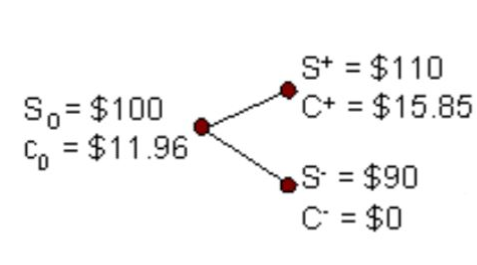    
where $\pi = (1+r -d)/(u-d) = (1.06-0.9)/(1.1-0.9)=0.8 $. Using this information, and assuming the expected value of the option is 15.85 (see below for an explanation of where this value comes from), we can calculate the present value of the call option today as:  

$c = PV[\pi c^ + (1-\pi)c^-] = (0.8*15.85 +0.2*0)/1.06 = \dollar11.96$    

It is appropriate to discuss <mark>delta</mark> at this stage. The delta of an option is the ratio of the change in the price of the option to the change in the price of the underlying. Therefore, it measures the sensitivity of the option price with respect to a change in the price of the underlying. Later, we will reconsider this alongside other greeks. In this particular example, the value of the delta of the call option being considered is    
- $\frac{15.85-0}{110-90} = 0.7925$.    

Delta corresponds to the number of units of the underlying that we should hold for each option shorted in order to create a riskless hedge. This rsikless hedge is sometimes referred to as <mark>delta hedging</mark> and if you are completely hedged, the overall position has a delta of zero, which is often referred to as being <mark>delta neutral</mark>. It is important to realize that the position only remains delta neutral for a relatively short period of time because delta changes. 
<div class="alert alert-block alert-info">
<b>Tip:</b> 
Do not take the delta calculated in this example very serious. Usually an ATM options has a delta of approximately 50. The reason why we are so far of is that delta is a simply approximation of the change, a first order derivative. Option payoffs are non linear. Therefore, the value is only reliable for small changes in the price of the underlying. In our example here, we have a change or $\pm10$ which is a very large change. Also, when delta changes, the hedge has to be adjusted, or <mark> rebalanced</mark>. This is where <mark>gamma</mark> comes into play, but we will postpone this discussion for now.  
</div>  

#### Two-period binomial model   
A natural extension is to include more periods. If we add on period, we get an additional up and down arc for each node. Assume the exercie price of an option is $\dollar$100. We keep the assumotuion that the price of a stock is $\dollar$100 and it can rise or fall by $\pm10$% in the period. Therefore, we obtain

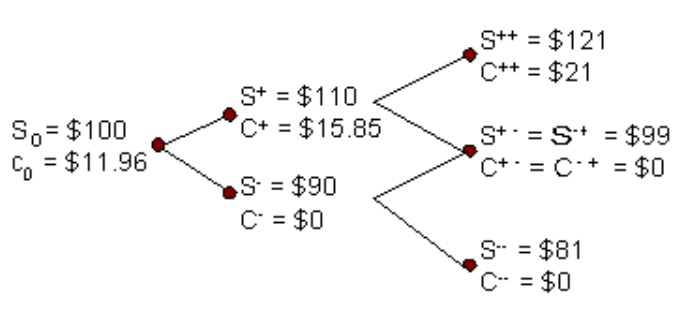  
This is a result of the potential stock prices at expiration and the corresponding value of the call option. The potential stock prices will be:    
- $S^{++} = 100*1.1*1.1=\dollar121$    
- $S^{+-} = S^{-+} = 100*1.1*1.1=\dollar99$    
- $S^{--} = 100*0.9*0.9 = \dollar81$   

Note that for computational reasons, it is extremely useful to use a recombining lattice ($S^{+-} = S^{-+}$) because the number of nodes will always only by n+1, where n is the number of time steps. In contrast, a non-recombining lattice will have $2^n$ nodes, which poses a tremendous computational challenge. 

In [2]:
def nodes(time_steps):
    non_recomb = 2**time_steps
    return "A recombining lattice uses only {} nodes, whereas a non-recombing lattice would use {} nodes for {} time steps.".format(time_steps+1, non_recomb, time_steps)

In [3]:
nodes(20)

'A recombining lattice uses only 21 nodes, whereas a non-recombing lattice would use 1048576 nodes for 20 time steps.'

When the option expires we get  
- $c^{++} = max(0,S^{++}- 100) = \dollar21$    
- $c^{+-} = c^{-+} max(0,S^{++}- 100) = \dollar21$
- $S^{+-} = S^{-+} = 100*1.1*1.1=\dollar0$    
- $S^{--} = 100*0.9*0.9 = \dollar81$   

Now, $\pi$ is still computet the same way. Therefore, we can calculate the value at each node, say $S^{++}$ as:   
$c^+ = PV[\pi c^{++} + (1-\pi)c^{+-}] = (0.8*21+0.2*0)/1.06 = \dollar15.85$ which is exactly the value we used in the one period example.   

The two-period binomial option valuation model illustrates two important concepts; self-financing and dynamic replication.   
- <mark> Self-financing</mark> implies that the replicating portfolio will not require any additional funds (Rule #1 of the arbitrageur). If additional funds are needed, then they are financed externally through borrowing.   
- <mark> Dynamic replication</mark> means that the payoffs from the option can be exactly replicated through a plaaned trading strategy.   

The hedge ratio calculation will apply to all cases throughout the binomial tree. Hence, we have different h at each node.  
- $h = \frac{c^+ - c^-}{S^+ - S^-}$   
- $h^+ = \frac{c^{++} - c^{+-}}{S^{++} - S^{+-}}$    
- $h^- = \frac{c^{-+} - c^{--}}{S^{-+} - S^{--}}$   

From the no arbitrage approach, the call payoffs can be replicated by purschasing h shares of the underlying and financing $-PV(-hS^- + c^-$. Therefore, the investor purchases $h = \frac{c^+ - c^-}{S^+ - S^-}  = (15.85 - 0)/(110-90) = 0.7925 $ shares of stock for $\dollar79.25 \  (0.7925*100)$ and borrow $\dollar67.288$ or in cashflow terms, $-67.288$.    
Moving to time t=1 will result in the stock position being worth $\dollar87.175$ and borrowing must be repaid with interest, which results in $\dollar71.325$. The portfolio net worth is $\dollar15.85$, which is exactly the value of the call option we tried to replicate. Therefore, the portfolio dynamically replicates the value of the call option.  

In [4]:
call_up = 15.85
call_down = 0 
S_up = 110
S_down = 90
r = 0.06

h = (call_up-call_down)/(S_up-S_down)
print("The hedge ratio is {}".format(h)) 
borrow = -(1/(1+r))*(-h*S_down + call_down)
print("The investor borrows ${}".format(round(borrow,3)))
stock_value = h*S_up
print("The stock position at the end of the first period is worth ${}".format(stock_value))
print("The amount borrowed must be repaid with interest, which results in ${}".format(borrow*(1+r)))
print("The portfolio net worth is ${} at the end, which is exactly the value of the call option.".format(round(stock_value-borrow*(1+r),2)))

The hedge ratio is 0.7925
The investor borrows $67.288
The stock position at the end of the first period is worth $87.175
The amount borrowed must be repaid with interest, which results in $71.325
The portfolio net worth is $15.85 at the end, which is exactly the value of the call option.


#### Multi-period model  
We will not provide a lot of details for the multi-period model. Essentially it just adds more and more nodes and arcs and is therefore better capable to produce reliable and realistic results. Furthermore, the binomial model can be applied to any underlying instrument though frequently requiring some modifications. Fore example, currency options would require incorporating the foreign interest rate, futures option would require a binomial lattice of the futures prices and so forth.     

The model can be used to illustrate an interesting result. Assume a more complex situation where the stock price at initiation is still $\dollar$100. Let us consider 3 time steps for which the possible price increase is 20% and decrease is 10%. There are 8 possible combinations for the stock price movement in three periods: uuu,uud,udu,duu,udd,dud,ddu,ddd. Therefore, each has a probability of 1/8. However, you can see a pattern here:    
<h2 style='padding: 10px'>Binomial lattice results</h2><table class='table table-striped' >  <tr> <th>Event</th> <th>Probability</th> <th>Final Stock Price</th> </tr>  <tbody> <tr> <td scope='row'>3 up movements</td> <td>1/8</td> <td>$100*1.2^3 = 172.8$</td>  </tr> <tr> <td scope='row'>2 up and 1 down</td> <td>3/8</td> <td>$100*1.2^2*0.9 = 129.6$</td>  </tr> <tr> <td scope='row'>1 up and 2 down</td> <td>3/8</td> <td>$100*1.2*0.9^2 = 97.2$</td>  </tr> <tr> <td scope='row'>3 down movements</td> <td>1/8</td> <td>$100*0.9^3 = 72.9$</td>  </tr> <tr>  </tr> <tr>  </tr> </tbody> </table>   

Notice that the midrange values are 3 times more likely to occur as teh extreme values. This takes us already one step towards explaining the <mark>[central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)</mark>. However, lets make this even simpler, by thinking of a fair dice. There are six sides, each equally likely to occur. Therefore, there is a chance of 1/6th that it ends up on any particular side. The distribution of the numbers that turn up from a dice roll is uniform given the equal likelihood. Let us generate a specific number of random dice rolls (e.g. 100) between 1 and 6. We know that the population mean value of the distribution is 3.5 calculated as (1 + 2 + 3 + 4 + 5 + 6) / 6 or 21 / 6. The resultig sample mean of any given sample will naturally only be close the the true value. 

In [5]:
# generate random dice rolls
seed(1)
# generate a sample of die rolls
def dice_roll(iterations):
    rolls = randint(1, 7, iterations)
    if iterations < 101:
        print(rolls)
    print("The sample mean of the {} rolls is {} which is not far from the population mean of 3.5".format(iterations, mean(rolls)))
 

In [6]:
dice_roll(100) 

[6 4 5 1 2 4 6 1 1 2 5 6 5 2 3 5 6 3 5 4 5 3 5 6 3 5 2 2 1 6 2 2 6 2 2 1 5
 2 1 1 6 4 3 2 1 4 6 2 2 4 5 1 2 4 5 3 5 1 6 4 2 3 1 5 2 3 3 2 1 2 4 6 5 4
 6 2 4 1 1 3 3 2 4 5 3 1 1 2 2 6 4 1 1 6 6 5 6 3 5 4]
The sample mean of the 100 rolls is 3.38 which is not far from the population mean of 3.5


We can then repeat this process numerous times, say 5000. This will give us a result of 5000 sample means. According to the central limit theorem, the distribution of these sample means will be <mark>[Gaussian](https://en.wikipedia.org/wiki/Normal_distribution)</mark>, also called the <mark>normal distribution</mark>. Let's plot the resulting distribution of sample means. Try re-running the code a few times to see that every outcome will be somewat different. You can also have a look at the [Bean Machine](https://en.wikipedia.org/wiki/Bean_machine) invented by Sir Francis Galton to see the possibly the simplest demonstration of the central limit theorem. 

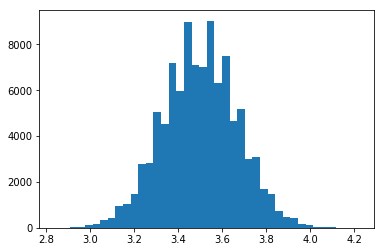

In [7]:
# calculate the mean of 100 dice rolls, repeated 10000 times
means = [mean(randint(1, 7, 100)) for i in range(100000)]
# plot the distribution of sample means
count, bins, ignored = plt.hist(means, 40, align='mid')
plt.show()

### That's it for the basics: let us have a closer look at the BSM model
We now have enough basic knowledge to get into the details of the BSM model. As already explained in the introducation, the BSM model is essentially the <mark>no-arbitrage</mark> approach, applied to a continuous time process, which is equivalent to a binomial model in which the lenght of the time step essentially approaches zero. We showed above that the binomial process with a "large" number of steps converges to the normal distribution. Recall that the no-arbitrage approach requires self-financing and dynamic replication, which implies that more than just an assumption regarding the terminal distribution of the underlying instrument is needed. We need to model the value of evolution of the underlying over time. 

Therefore, one of the key assumption for option valuation is how to model the random nature of the underlying instruments. The charactersitic of how the asset evolves is usually thought of being random, a stochastic process. Bachelier proposed to use the <mark>[Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution)</mark> to model stock prices. 
- Key advantages are that it is symmetric, relatively easy to manipulate, zero (bancruptcy) is possible and it is additive (the sum of normal distributions is also normally distributed). You can refer to the section on distributions to find some explanation about this. 
- Key disadvantage is that negative stock values are theoretically possible, which violates the principle of limited liability of stock ownership.    

[Fischer Black](https://en.wikipedia.org/wiki/Fischer_Black), [Myron Scholes](https://en.wikipedia.org/wiki/Myron_Scholes)  and [Robert C. Merton](https://en.wikipedia.org/wiki/Robert_C._Merton) proposed to use the <mark>log-normal distribution</mark>. Modelling option prices with <mark>[Geometric Brownian Motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)</mark> implies a log-normal distribution of returns, meaning that the continuously compounded logarithmic return is normally distributed. 
<div class="alert alert-block alert-info">
<b>Tip:</b> Check out the section "Why the natural logarithm is such a natural choice" for an explantion of this. 
</div>   

Essentially, a variable x (stock price returns in this case) has a log-normal distribution if log(x) is normally distributed. A stochastic process $S_T$ is said to follow a GBM if it satisfies the following <mark>[stochastic differential equation](https://en.wikipedia.org/wiki/Stochastic_differential_equation)</mark> (SDE):

$ dS_t = \mu S_t\,dt + \sigma S_t\,dW_t $

where $W_t$ is a <mark>[Wiener process](https://en.wikipedia.org/wiki/Wiener_process)</mark>, also called <mark>standard Brownian motion</mark>, and $\mu$ ('the percentage drift' which is an annual, geometrically compounded rate) and $\sigma$ ('the percentage volatility') are kown and constant.

The former is used to model deterministic trends, while the latter term is used to model a set of unpredictable events occurring during this motion. The random component of Geometric Brownian motion is determined by volatilty ($\sigma$), which reflects the annualized standard deviation of continuously compounded percentage changes in the underlying. Note that as a particular sample drifts upward, we observe more variability in absolute terms and less variability if it drifts downwards. This can also be seen in the chart below. The lowest lines are a lot less erratic than the highest lines. This is a simply result of a 10% move in the underlying when the price is 100, corresponds to a move of 10, whereas if the underying price is 10, the move is only 1. While these movements are rather erratic, there are no large jumps, another common feature with marketable financial instruments.   

Another appealing feature is that GBM can never hit zero or go below it. This property is very appealing because many financial instruments enjoy limited liability and cannot be be negative. However, with very low or even negative interest rates in some countries, it is no longer reasonable or even [possible](https://uk.mathworks.com/help/fininst/work-with-negative-interest-rates.html) to use a model that does not allow negative rates. We will not delve into this much detail here, as [interest rate models](https://www.fincad.com/blog/interest-rate-models-and-negative-rates) require modifications of the BSM model, with or without negative interest rates. The Fixed income section explains some of these models.   

In [8]:
CONTROL_LAYOUT = {'border': '1px solid', 'width': '20%', 'min_width': '350px'}
GRAPH_LAYOUT = {'border': '1px solid', 'width': '80%'}


class Model:

    controls = []
    graphs = []
    header = ''

    def _ipython_display_(self):
        controls = VBox(self.controls, layout=CONTROL_LAYOUT)
        graphs = VBox(self.graphs, layout=GRAPH_LAYOUT)
        model = HBox([controls, graphs]).add_class('theme-dark')
        header = HTML("<h1 style='color:darkorange'>{}</h1>".format(self.header))
        display(header)
        display(model)
        return True


In [9]:
class Chart(Figure):
    def __init__(self, c_type='line', title='', x_label='', y_label='', **kwargs):
        super(Figure, self).__init__()
        self.x_sc = LinearScale()
        self.y_sc = LinearScale(min=kwargs.get('min'), max=kwargs.get('max'))

        self.x_sc_hist = LinearScale()
        self.y_sc_hist = LinearScale()

        self.line = Lines(x=[], y=[], scales={'x': self.x_sc, 'y': self.y_sc},
                          stroke_width=3, display_legend=False, labels=['Line chart'])

        self.ax_x = Axis(scale=self.x_sc, grid_lines='solid', label=x_label)
        self.ax_y = Axis(scale=self.y_sc, orientation='vertical', tick_format='0.2f',
                         grid_lines='solid', label=y_label)

        self.hist = Hist(sample=[], scales={'sample': self.x_sc_hist, 'count': self.y_sc_hist})
        self.ax_x_hist = Axis(scale=self.x_sc_hist, tick_format='0.0f')
        self.ax_y_hist = Axis(scale=self.y_sc_hist, orientation='vertical')

        self.type_dict = {'line': self.line, 'hist': self.hist}
        
        self.marks=[self.type_dict[c_type]]
        self.axes=[self.ax_x, self.ax_y, self.ax_x_hist, self.ax_y_hist]
        self.title=title 
        self.animation_duration=300
        self.min_aspect_ratio=1
        self.max_aspect_ratio=10
        self.fig_margin={'top': 40, 'bottom': 40, 'left': 60, 'right': 20}
        self.legend_location='bottom-right'
        self.layout=Layout(flex='1 1 auto', width='100%', height='auto',min_height='300px')
        

In [10]:

class GeometricBrownianMotion(Model):
    def __init__(self):
        self.simChart = Chart('line', 'Monte Carlo Simulation', 'Time', 'Price')
        self.histChart = Chart('hist', 'Distribution of Final Asset Price', 'Asset Price', 'Occurrences')
        self.paths = IntSlider(description="Paths", min=1, max=100, value=50)
        self.steps = IntSlider(description="Steps", min=12, max=252, value=52)
        self.vol = FloatSlider(description="sigma", min=0, max=1, value=0.05, step=0.001)
        self.spot = Text(description="S", value='100')
        self.risk = FloatSlider(description="Rf", value='0.05', min=-0.25, max=0.25, step=0.01)
        self.expiry = FloatSlider(description="T", value='1', min=0.25, max=30, step=0.25)

        self.vol.observe(self._process_wrapper, 'value')
        self.paths.observe(self._process_wrapper, 'value')
        self.steps.observe(self._process_wrapper, 'value')
        self.risk.observe(self._process_wrapper, 'value')
        self.expiry.observe(self._process_wrapper, 'value')
        self.spot.observe(self._process_wrapper, 'value')

        self.header = "Black-Scholes Diffusion"
        self.controls = [self.spot, self.paths, self.steps, self.vol, self.risk, self.expiry]
        self.graphs = [HBox([self.simChart, self.histChart])]
        self._process_wrapper()

    def _process_wrapper(self, click=None):
        mc = self.gmb()
        self.simChart.line.x = mc.columns
        self.simChart.line.y = mc
        self.histChart.hist.sample = mc.iloc[:, -1]
        self.histChart.hist.bins = int(self.paths.value / 3)

    def gmb(self, click=None):
        # Black Scholes
        # Geometric Brownian Motion Diffusion

        I = int(self.paths.value)  # Paths
        S0 = float(self.spot.value)  # Price as T0
        r = float(self.risk.value)  # Risk free rate
        sigma = float(self.vol.value)  # Volatility
        T = float(self.expiry.value)  # Time to expiry in years
        M = int(self.steps.value)  # Steps
        dt = T / M
        S = np.zeros((M + 1, I))
        S[0] = S0
        for t in range(1, M + 1):
            S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt
                                     + sigma * np.sqrt(dt) * npr.standard_normal(I))

        # Converting the Numpy array to a pandas DataFrame
        mc = pd.DataFrame(S).T
        return mc


In [11]:
GeometricBrownianMotion()

### Assumptions of the BSM model    
- The underlying follows a stochastic process called Geometric Brownian motion (see above) 
- The volatility of the return is known and constant 
- The [continuously compounded](https://www.investopedia.com/terms/c/continuouscompounding.asp) risk free rate is known and constant and one can borrow and lend at the risk free rate. 

<div class="alert alert-block alert-info">
<b>Tip:</b> 
Suppose $r_c$ is the rate of interest with continuous compounding, and $r_d$ is the equivalent rate with compounding m times per annum. You can easily convert bewteen discrete and continous interest rates with teh following equations:    
 $r_c = m*ln\Bigg(1+\frac{r_d}{m}\Bigg)$ and    
 $ r_d = m(e^{r_c/m}-1)$
</div>  
  
- This requires no market frictions (no transcation costs, no regulatory constraints or taxes)
- As a result, short selling of the instrument with full use of the proceeds is permitted
- GBM implies continuous prices and no jumps 
- This in turn implies that continuous trading is available (in the strictest sense, you must be able to trade at every instant)
- Which requires that the underlying instrument is liquid (meaning it can be easily bought and sold)
- The options are European-style, meaning that early exercise is not allowed (this implies that <mark>path-dependent</mark> options cannot be modelled)   

Naturally, these assumptions are not consistent with real financial markets, but, as in all fincancial models, there need to be simplifications to make the model tractable and useful. Numerous extension and modifications were developped and yet, the BSM model is very robust, reliable and commonly used for <mark>[plain vanilla](https://www.investopedia.com/terms/p/plainvanilla.asp)</mark> options. 

The BSM model for non-dividend-paying stocks can be expressed as:   
- $c = SN(d_1) -e^{-rT}XN(d_2)$ for calls and 
- $p = e^{-rT}XN(-d_2) - SN(-d_1)$ for puts,  

where   


- $d_1 = \frac{ln(S/X)+(r + \sigma^2/2)T}{\sigma \sqrt{T}}$
- $d_2 = d_1 -\sigma \sqrt{t}$   

$N(x)$ denotes the <mark>[standard normal](http://mathworld.wolfram.com/StandardNormalDistribution.html)</mark> <mark>[cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function)</mark>, which is the probability, or likelihood, of obtaining a value of less than x, from a random sample of observations taken from the standard normal distribution with mean $\mu =0$ and standard deviation $\sigma =1$ commonly denoted as $N(\mu,\sigma)$. This may look very complicated but the interpretation is straightforward. It the chart below, you can see how the CDF at a value of 0.5 corresponds to maximum likelihood of the <mark>[probability density function (PDF)](https://en.wikipedia.org/wiki/Probability_density_function)</mark> (the standard bell shaped curve) which is exactly at its mean. The density function generates the cumulative distribution function. We will encounter this again in the section explaining the option sensitivity parameter Gamma. The normal distribution is a symmetric distribution, and the first and second [moment](https://en.wikipedia.org/wiki/Moment_(mathematics) describe the distribution completely. Therefore, we know that the most likely value is the mean. Symmetry implies that 50% of the values will lie to the left and 50% to the right. Therefore, $N(-x) = 1-N(x)$. Since the CDF accumulates the probabilities it ranges from 0 to 1.    

In [10]:
x = np.linspace(norm.ppf(0.0001),
                 norm.ppf(0.9999), 100)

plt.style.use('dark_background')
plt.figure(figsize=(12,7))
plt.title('Standard Normal Distribution',fontsize = 12, color = 'w')
plt.xlabel('Outcome', fontsize = 12)
plt.ylabel('Distribution and Density',fontsize = 12)

plt.plot(x, norm.pdf(x),
       'r-', lw=2, alpha=0.6, label='Standard Normal PDF')
plt.plot(x, norm.cdf(x),
       'b-', lw=2, alpha=0.6, label='Standard Normal CDF = N(x)')
plt.axvline(x=0,linewidth=0.5, color='g')
plt.axhline(y=0.5,linewidth=0.5, color='g')

bbox_props1 = dict(boxstyle="Darrow,pad=0.1", fc="none", ec="c")
bbox_props2 = dict(boxstyle="Darrow,pad=0.1", fc="none", ec="c")
bbox_props3 = dict(boxstyle="Darrow,pad=0.1", fc="none", ec="c")
plt.text(-0.9, 0.1, "  68% within 1 SD band  ", ha="left", va="center", 
        size=12,
        bbox=bbox_props1)
plt.text(-1.96, 0.04, "         95% within 2 SD band (1.96 to be precise)      ", ha="left", va="center", color="w",
        size=12,
        bbox=bbox_props2)
plt.text(-3, 0, "99.7% of observations lie within the 3 SD band - large outliers are very unlikely", ha="left", va="top",
        size=12,
        bbox=bbox_props3)

plt.legend()
plt.show()

NameError: name 'np' is not defined

It is appropriate to explain the PDF values at this stage. You may probably remember from highschool that there is the general rule that 95% of all observations fall within the 2 standard deviation band. Strictly speaking, it is $\pm1.96$. Making use of of the "magic" of [Gaussian Quadrature](https://www.youtube.com/watch?v=k-yUdqRXijo) we approximate the integral under the curve and calculate the values. This allows us to calculate the percent of observations that fall within a certand Standard deviation band. For the 3 standard deviation band we also include the error term from the exact integral versus Gaussian quadrature, which is amazingly small as you can see below. 

<div class="alert alert-block alert-info">
<b>Tip:</b> 
To see how Gaussian quadrature can be used in Option pricing you can have a look and [Nuno Reis' Linkedin post about Collocating Local Volatility](https://www.linkedin.com/pulse/three-easy-steps-run-monte-carlo-simulations-faster-full-nuno-reis/)  
</div>  

In [13]:
# Numpy example: calculate the integral of the standard normal distribution

phi = norm()

standard_deviation_1= 1
standard_deviation_2= 1.96
standard_deviation_3= 3

value1, error = quad(phi.pdf, -10, 0) # Integrate using Gaussian quadrature
value2, error = quad(phi.pdf, -standard_deviation_1, standard_deviation_1) 
value3, error = quad(phi.pdf, -standard_deviation_2, standard_deviation_2) 
value4, error = quad(phi.pdf, -standard_deviation_3, standard_deviation_3) 

print("{}% of observations lie below the mean of 0".format(round(value1*100,3)))
print("{}% of observations fall withing the {} SD band".format(round(value2*100,3), standard_deviation_1))
print("{}% of observations fall withing the {} SD band".format(round(value3*100,3), standard_deviation_2))
print("{}% of observations fall withing the {} SD band".format(round(value4*100,3), standard_deviation_3))
print("Gaussian Quadrature results in an error of {:.15f} relative to the true value.".format(Decimal(error)))

50.0% of observations lie below the mean of 0
68.269% of observations fall withing the 1 SD band
95.0% of observations fall withing the 1.96 SD band
99.73% of observations fall withing the 3 SD band
Gaussian Quadrature results in an error of 0.000000000000011 relative to the true value.


The BSM model can be described as the present value of the expected option payoff at expiration. The present value term in this context is simply $e^{-rT}$. The expectation is based on <mark>risk-neutral probability</mark> as explained above. Just like the binomial model, the BSM model can be desribed as having two components:   
- stock component which is $SN(d_1)$ for calls and $S-N(-d_1)$ for puts 
- bond component which is $e^{-rT}XN(d_2)$ for calls and $e^{-rT}XN(-d_2)$ for puts    

The BSM call value is the stock component minus the bond component, $c = SN(d_1) -e^{-rT}XN(d_2)$ . For puts, it is the bond component minus the stock component $p = e^{-rT}XN(-d_2) - SN(-d_1)$. This is a result of the replication strategy where the BSM model can be interpreted as a dynamically managed portfolio of stock and bond components, with the goal to replicate the option payoff. This logic is identical to the binomial model explained above. Instead of the hedge ratio, we have the standard normal distribution that determines the amount. You buy stock, with an amount equal to $N(d_1)$ and finance it by borring money for calls. Therefore, a call option can be viewed as a leveraged position in the stock. On the other hand, for puts, you short sell stock with an amount equal to $N(-d_1)$ and buy bonds with the proceeds, which means you are effectively lending money. The price of the zero coupon bond is $e^{-rT}X$. If appropriately rebalanced, this strategy will replicate the payoff of the call or put option respectively. If the value of the underlying, S, increases, the value of $N(d_1)$ also increases because S has a positive effect on $d_1$. Therefore, the replicating strategy for calls requires continually buying shares in rising markets and selling shares in falling markets. The aggregate losses of "buy high/sell low" over the life of the option add up exactly to the BSM model option premium at inception. This is an implication of the no-arbitrage pricing.   


<h2 style='padding: 10px'>BSM and Binomial option valuation model comparison</h2>
<table class='table table-striped' >  
<tr style="background-color:black;color:white;"> 
<th>Model</th> <th>Call underying</th> <th>Financing</th> <th>Put underlying</th> <th>Lending</th> </tr>  
<tbody> 
<tr style="background-color:black;color:white;"> 
<td scope='row'>Binomial Model</td> <td>$hS$</td> <td>$PV(-hS^- +c^-)$</td> <td>$hs$</td> <td>$PV(-hS^- +p^-)$</td> </tr> 
<tr style="background-color:black;color:white;"> 
<td scope='row'>Black Scholes Model</td> <td>$SN(d_1)$</td> <td>$-e^{-rT}XN(d_2)$</td> <td>$- SN(-d_1)$</td> <td>$e^{-rT}XN(-d_2)$</td> </tr> <tr>  
</tr> <tr>  </tr> <tr>  </tr> 
</tbody> 
</table>

### Implied volatility  
It is a good place to reconsider the assumptions of the BSM model here. Recall that transaction costs are assumed to be zero (frictionless markets), which in fact, they are not. Frequently rebalancing by buying and selling the underlying adds significant costs for the hedger. Furthermore, markets can often move discontinuously and do not trade 24/7. Hence, in reality, hedges are imperfect. Also, volatility is not constant and known in advance. For this reason, options are frequently more expensive and the <mark>implied volatility</mark> (often just called volatility of vol) used in the option pricing is usually higher than the volatility of the underlying. **include VOLC screenshot or equity or both** 

<div class="alert alert-block alert-info">
<b>Tip:</b> 
You may have learned that implied volatility is a result of the option pricing model. That is true in the original BSM model, where listed option prices are used as an input. However, in <mark>[over-the-counter (OTC)](https://www.investopedia.com/terms/o/otc.asp)</mark> option trading, participants use volatility as the medium in which to quote options. In this case, options are generally priced by using implied volatility as an input for reason we will elaborate below. 
</div>   

Volatility is not directly observable. You can estimate it based on a sample of historical data. However, the volatility parameter $\sigma$ in the BSM model is future volatility. Much like yield to maturity with bonds, volatility can be inferred from option prices, which is why the term implied volatility is used. Therefore, for listed options, implied volatility provides information regarding the perceived uncertainty going forward, thereby allowing us to get an understanding of the collective opinions of investors on the volatility of the underlying and the demand for options.    

In practice it is very common to observe different implied volatilities for different exercise prices and calls versus puts with the same term. The shape of the <mark>[volatility surface](https://www.investopedia.com/articles/stock-analysis/081916/volatility-surface-explained.asp)</mark> with respect to the exercise price is commonly known as the volatility <mark>[smile](https://en.wikipedia.org/wiki/Volatility_smile)</mark>.  Implied volatility also varies across time to expiration known as the <mark>term structure of volatility</mark>. During crises, the higher implied volatility is a result of the combined effect of higher expected future volatility and increased preference ofr buying, rather than selling options, which drives up the price of options, and hence volatility.   

In OTC markest, the price is calculated by using implied volatility as an input. There are severl benefits of quoting via implied volatility:    
- it allows volatility to be traded in its own right  
- it is always annualized and therefore easily comparable across exercise prices and expiration dates: you will always know that 20% implies vol is higher than 10% but it is difficult to determine if a deep OTM option is relatively more expensive than an ATM option if you only look at the price  
- implied volatility, together with standard pricing models give the market consensus valuation: there are calls and puts, various exercise prices, various maturities, American and European options (as well as more exotic options), exchange traded options and OTC options; thus, it is difficult to conceptualize all these different prices - it is easier to understand and compare option prices when looking at implied volatility (e.g. saying an option trades for $\dollar$15.85 reveals nothing about its relative price which depends on the moneyness and the remaining life of the option; by looking at annualized implied volatility, the investor has a directly comparable metric)
- quoted implied vol can account for a number of shortcomings of the BSM model   

The last point is crucial. In reality, log returns do not exactly follow a normal distribution but frequenty exhibit <mark>[skewness](https://en.wikipedia.org/wiki/Skewness)</mark> and <mark>[kurtosis](https://en.wikipedia.org/wiki/Kurtosis)</mark>. Skewness and Kurtosis are the third and fourth [moment](https://en.wikipedia.org/wiki/Moment_(mathematics). We already encountered the first (mean $\mu$) and second (standard deviation $\sigma$) in our discussion about the standard normal distribution. Skewness is related to differences in the prices (implied vol) of call versus put options and is a result of market sentiment as well as the supply and demand relationship. Kurtosis on the other hand, if <mark>leptokurtic</mark> states that the likelyhood of outliers is higher than the normal distribution suggests. Recall that based on the normal distribution, we showed that 99.7% of all observations fall within the $\pm3 SD$ band. If the distribution is leptokurtic, the probability of values that fall outside the 3 SD band is higher than 0.3 (100-99.7). Clearly, if real world returns exhibit skewness and kurtosis, using a single implied volatility quote would not be ideal. Therefore, the market develloped tools that account for this shortcoming. We will illustrate this by explaining how implied volatility is quoted in FX option markets.    

<font size="5" color="lightskyblue">The FX Volatility surface and the Volatility Smile</font>
<p><p>
<font size="3"> 
<p>
In FX, we use three different types of instruments to create a vol surface: ATM options, risk reversals and butterfly's. Using vanilla instruments we can set up these equalities:
$$
RR = Vol_c \ - \ Vol_p 
$$
<p>
$$
BF = \frac{Volc_c + Vol_p}{2} \ - \ ATM
$$
<p>
this leads us to:
<p>
$$
BF = \frac{Vol_c + Vol_c - RR}{2} - ATM 
$$
so that finally:
<p>
$$
Vol_c = ATM + \frac{RR}{2} + BF 
$$
<p>
To create a little app to view the smile for different levels of ATM, RR and BF's we first need a couple of visualisation tools. You will see that ATM vols control the vol level, the risk reversals the skew and BF's the curvature (kurtosis). If you set RR and BF equal to zero, you end up with the canonical BSM assumption of constant implied vol. 
<p>
Let's have a look at how we can visualise this using Python:
</font>

In [14]:
class VolSmile(Model):
    def __init__(self):
        self.VolSmileChart  = Chart('line', 'Volatility Smile', 'Put Delta', 'Implied Volatility', min=0.01, max=0.5)

        self.ATM = FloatSlider(description="ATM", value='0.15', min=0.00, max=0.5, step=0.01)
        self.RR = FloatSlider(description="RR", value='0.06', min=-0.25, max=0.25, step=0.01)
        self.BF = FloatSlider(description="BF", value='0.06', min=0.00, max=0.1, step=0.01)

        self.ATM.observe(self._process_wrapper, 'value')
        self.RR.observe(self._process_wrapper, 'value')
        self.BF.observe(self._process_wrapper, 'value')

        self.header = "Implied Volatility Smile"
        self.controls = [self.ATM, self.RR, self.BF]
        self.graphs = [HBox([self.VolSmileChart])]

        self._process_wrapper()

    def _process_wrapper(self, click=None):
        put_deltas = np.array(
            [0.001, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9,
             0.95, 0.999])

        ivols = self.malz(put_deltas)

        self.VolSmileChart.line.x = put_deltas
        self.VolSmileChart.line.y = ivols

    def malz(self, put_delta):
        return self.ATM.value + 2 * self.RR.value * (put_delta - 0.5) + 16 * self.BF.value * (put_delta - 0.5) ** 2


In [15]:
VolSmile()

### Black option valuation model   
In 1976, [Fischer Black](https://www.scribd.com/document/105258441/3-The-pricing-of-commodity-contracts) introduced a modified version of the BSM model that can be used on underlying instruments that are costless to carry, such as options of <mark>futures contracts</mark> or <mark>forward contracts</mark>. A slightly modified version can also be used for interest rate based options such as [caps, floors](https://en.wikipedia.org/wiki/Interest_rate_cap_and_floor) and [swaptions](https://en.wikipedia.org/wiki/Swaption). It is often also called <mark>Black76</mark>.   

The cost of carry is summarizing the relationship between spot and future prices. It is a measure of the carry benefits (fore example, dividends, foreign interest rates, bond coupon payments and so forth) and carry costs (for example storage costs, waste for example form spoilage, insurance; which mainly apply to commodities and are essentially 0 for finanicial instruments). Let $\gamma$ denote carry benefits, and $\theta$ denote carry costs. While there are no direct carry costs for finanical instruments, there are still opportunity costs of the interest that could be earned on the money tied up in the asset. Thus, financing costs that come form the rate of interest and teh carry cost that are common to physical assets are equivalent concepts. The carry arbitrage model with continuous compounding is the future value F of the underlying S adjusted for carry and can be expressed as:     

$F_0(T) = S_0e^{(r_c+\theta -\gamma)*T}$ where $F_0(T)$ denotes the future value today, for expiry at time T    

This holds in general for all forward and future contracts with some modifications. For example, in the case of bond futures, you need an adjustment for delivery of multiple bonds called conversion factor and if you use the clean price you need an additional adjustment for this. Furthermore, forward and future prices are not identical due to differences in margin requirements, mark-to market features, centralized clearing and so forth. We will not delve into the exact differences but only provide a simple example. Consider a case where the underlying is highly positively correlated with interest rates. Therefore, when S increases, an investor who holds a long futures position makes an immediate gain because of the daily settlement procedure. This gain will tend to be invested at a higher than average interest rate. Likewise, if S decreases, the investor will make an immediate loss which will tend to be financed at a lower than average interest rate. An ivestor holding a forward contract rather than a futures contract will be unaffected by this. It follows that long futures contracts should be more attractive compared to the forward contract. Similarly, if S is negatively correlated with interest rates, the exact opposite holds. In any case, the futures contract is already reflecting the carry arbitrage price. 

#### European options on Futures   
It is still assumed that the futures price follows a geometric Brownian motion. Ignoring issues like margin requirements and marking to market, Black proposed the following model for European-style futures options:  

- $c = e^{-rT}[F_0(T)N(d_1) - XN(d_2)]$ for calls and 
- $p = e^{-rT}[XN(-d_2) - F_0(T)N(-d_1)]$ for puts,  

where   


- $d_1 = \frac{ln[F_0(T)/X] + (\sigma^2/2)T}{\sigma \sqrt{T}}$
- $d_2 = d_1 -\sigma \sqrt{t}$   

Comparing Black's model with the BSM model shows that it is simply the BSM model in which the futures contract is assumed to reflect the carry arbirtage model. Similar to the BSM model, we can describe the call option as two components:

- futures component which is $F_0(T)e^{-rT}N(d_1)$ for calls and $F_0(T)e^{-rT}N(-d_1)$ for puts 
- bond component which is again $e^{-rT}XN(d_2)$ for calls and $e^{-rT}XN(-d_2)$ for puts    

The Black call value is the future component minus the bond component and for puts, it is the bond component minus the futures component. This is a result of the replication strategy where the Black model can be interpreted as a dynamically managed portfolio of futures and bond components, with the goal to replicate the option payoff. This logic is identical to the binomial model as well as the BSM model explained above. However, there is a simpler interpretation here. The futures option value is simply the present value of the difference between the futures price and the exercise price adjusted for N(x).    

The payoff from a European spot call option is $max(S_T - X,0)$ where $S_T$ is the spot price at maturity. The payoff from a European futures call option with the sam strike X is $max(F_0(T)-x,0)$. If the European Futures option matures at the same time as the futures contract we have $F_T =S_T$ and the two options are in theory equivalent. At expiration, both a forward and future contract are equivalent to a spot transaction in the underlying. This property is often called <mark>[convergence](https://www.investopedia.com/terms/c/convergence.asp)</mark>.    
However, Black's formula does not require that the options contract and the futures contract mature at the same time. If the European call futures opton matures before the futures contract, it is worth more than the corresponding spot option if the futures price is higher than the spot price (a situation called <mark>[contango](https://www.investopedia.com/terms/c/contango.asp)</mark>) and less than the corresponding spot option in an inverted market where the futures price is below the spot price (a situation called <mark>[backwardation](https://www.investopedia.com/terms/b/backwardation.asp)</mark>). A similar argument holds for put options, with teh opposite direction. If the put option matures before the futures contract and the market is in contango, it is worth less, if the market is in backwardation it is worth more. 

Greeks 



In [7]:
from scipy.stats import norm
from math import *

def BlackScholesCall(stock,strike,risk_free_rate,sigma,time,dividend_yield):
    # get variables for formula
    d1 = ((log(stock / strike) + (risk_free_rate - dividend_yield + 0.5 * sigma **2) * time) / (sigma * sqrt (time)))
    d2 = d1 - sigma * sqrt(time) 
    # get BSM call & put values
    call_price = stock * norm.cdf(d1) - strike * exp(-risk_free_rate*time)  * norm.cdf(d2)
    # get Greeks
    delta_call = exp(-dividend_yield*time)*norm.cdf(d1)
    gamma = exp(-dividend_yield*time)*norm.pdf(d1) / (stock * sigma * sqrt(time) )
    theta_call = -(stock * norm.pdf(d1) * sigma / (2 * sqrt(time))) - (risk_free_rate * strike * exp(-risk_free_rate*time) * norm.cdf(d2))
    rho_call = (time * strike * exp(-risk_free_rate*time) * norm.cdf(d2))
    vega = (stock * norm.pdf(d1) * sqrt(time))
    return "Put price {}, Delta {},Gamma {}, Theta {}, Rho {}, Vega {}".format(call_price,delta_call, gamma, theta_call,  rho_call, vega )

def BlackScholesPut(stock,strike,risk_free_rate,sigma,time,dividend_yield):
    d1 = ((log(stock / strike) + (risk_free_rate + 0.5 * sigma **2) * time) / (sigma * sqrt (time)))
    d2 = d1 - sigma * sqrt(time)
    put_price = - stock * norm.cdf(-d1) + strike * exp(-risk_free_rate*time)  * norm.cdf(-d2)
    delta_put =  -exp(-dividend_yield*time)*(norm.cdf(-d1))
    gamma_p = strike*exp(-risk_free_rate*time)*norm.pdf(d2) / (stock**2 * sigma * sqrt(time) )
    theta_put = -(stock * norm.pdf(d1) * sigma / (2 * sqrt(time))) + (risk_free_rate * strike * exp(-risk_free_rate*time) * norm.cdf(-d2))
    rho_put = (-time * strike * exp(-risk_free_rate*time) * norm.cdf(-d2))
    vega = (stock * norm.pdf(d1) * sqrt(time))
    return "Put price {}, Delta {},Gamma Put {}, Theta {}, Rho {}, Vega {}".format(put_price,delta_put, gamma_p, theta_put,  rho_put, vega )


In [8]:
BlackScholesCall(100, 100, 0.005, 0.06, 0.4, 0)

'Put price 1.6142761210606338, Delta 0.5285710345530259,Gamma 0.10486079971293322, Theta -2.1437085315040076, Rho 20.49713093369678, Vega 25.16659193110397'

In [9]:
BlackScholesPut(100, 100, 0.005, 0.06, 0.4, 0)

'Put price 1.4144759877939421, Delta -0.47142896544697405,Gamma Put 0.1048607997129332, Theta -1.644707532170341, Rho -19.42294901299654, Vega 25.16659193110397'

In [65]:
Black_Scholes_Greeks_Call(100, 100, 0.005, 0.06, 0.4, 0)

(0.5285710345530259,
 0.10486079971293322,
 -2.1437085315040076,
 25.166591931103973,
 20.49713093369678)

In [18]:
a = BlackScholes('c',100,100,0.005, 0.06, 0.4, 0)
b = BlackScholes('c',101,100,0.005, 0.06, 0.4, 0)
print("delta bump and reprice = {}".format(b-a))
new_call_delta_approx = a+0.5285710345530259*(101-100)
print("New call value = {}".format(new_call_delta_approx))
print("error ={}".format(b-new_call_delta_approx)) # get bump and reprice gamma as well 

delta bump and reprice = 0.5802069830559802
New call value = 2.1428471556136595
error =0.0516359485029545


TypeError: must be str, not numpy.float64

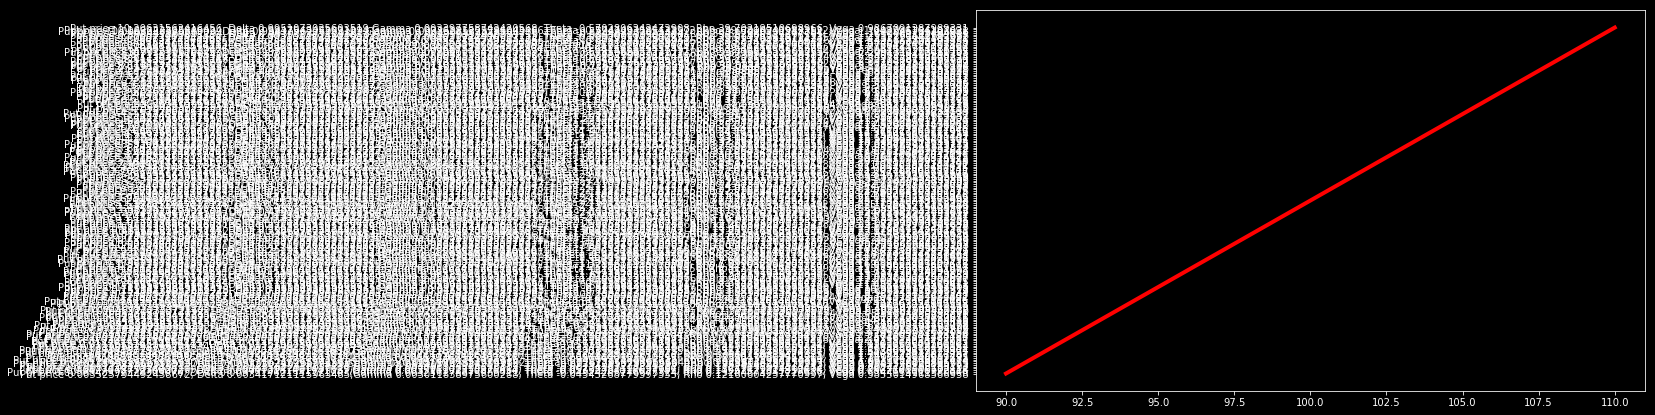

In [51]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,7))
plt.style.use('dark_background')
maturity = 0
S = np.linspace(90,110,200)
p = []
for i in S:
    p.append(BlackScholesCall(i, 100, 0.005, 0.06, 0.4, 0))
plt.plot(S,p, label = 'Call Value', linewidth=4,color='r')

d = []
for i in S:
    a = BlackScholesCall(100,100, 0.005, 0.06, 0.4, 0)
    d.append(BlackScholesCall( i, 100, 0.005, 0.06, 0.4, 0)-(a+0.5285710345530259*(i-100)))   
#ax.plot(d)   

delta_approx = []
for i in S:
    delta_approx.append(a+0.5285710345530259*(i-100))
plt.plot(S,delta_approx, label = 'Delta approximation',linewidth=2, linestyle='dashed',color='b')

gamma_approx = []
for i in S: 
    gamma_approx.append(a+0.5285710345530259*(i-100)+(0.10486079971293322/2)*((i-100)**2))
plt.plot(S,gamma_approx, label = 'Delta-plus-gamma approximation', linewidth=2, linestyle='dashed',color='g')

plt.legend(fontsize = 12)
plt.xlabel('Price of the underlying',fontsize = 12)
plt.ylabel('Call Value',fontsize = 12)
plt.title('Call Values, Delta Estimated Values, and Delta-Plus_gamma estimated values',fontsize = 12)
plt.grid(True,linewidth=0.2)

plt.show()

If you own options, you are exposed to price changes in the option that are a result of changes in prices of the inputs into the option valuation model. Understanding how sensitive option prices are to small changes in a particular parameter (inputs in the option pricing model) is essential for anyone managing option positions. These sensitivity parameters are called <mark>[Greeks](https://en.wikipedia.org/wiki/Greeks(finance)</mark>.
The general idea is to isolate the change in the option value for a small change in the selected parameters, holding all else equal <mark>[ceteris paribus](https://en.wikipedia.org/wiki/Ceteris_paribus)</mark>. Mathematically, this is simply the derivative of the price of the instrument with respect to the parameter of interest, but more on that later. This discussion will focus on the simple European stock options that pay dividend, though logic of the material covered in this section applies to all types of options.  

# Delta    
Delta is defined as the price change in a given instrument for a given small change in the value of the underlying (stock), holding all else constant. Consequently, delta of a long position in one stock is simply +1, and delta of short one share of stock is -1. This requires no math, just intuition. If we measure how something changes when the stock price changes, but that something is the stock price itself, it must obviously change one for one. Forwards and futures, ETFs, certain swaps among other products have a delta very close to one as well. Therefore, teams trading these instruments are often called [Delta One Desks](https://financetrain.com/what-are-delta-one-trading-desks/). 


<div class="alert alert-block alert-info">
<b>Delta of Futures versus Forwards:</b> 
This is a [frequently](https://quant.stackexchange.com/questions/11261/are-futures-exactly-delta-one) asked question that is not often answered properly (also not in the link). Recall that we defined the future value as $F_0(T) = S_0e^{(r_c+\theta -\gamma)T}$. Now, to make things simpler, assume there are no costs or benefits from holding the security. Therefore, the forward price of F must be the value to which S would grow if invested at the risk free rate: $F =Se^{rt}$ where subscripts were omitted for simplicety. Now, the value of a fair forward, called ([at-market](https://financetrain.com/off-market-forward-contracts/)), is zero at initiation. During the lifetime of the contract, it may have a positive or negative value. If we denote the current forward (delivery) price as $F$ and the originally negotiated delivery price as K, we can write:   
$f = (F-K)*e^{-rT}$. 
To give some intuition why this must be true, consider what happens at delivery. The differnce between the two is only the amount that will be paid in the future. The cash outflow difference is $F-K$ which translates into $(F-K)*e^{-rT}$ in today's prices. This equation can be combined with $F =Se^{rT}$ which results in   
$ f = S -K*e^{-rT} $   
Now, taking the <mark>[Derivative](https://en.wikipedia.org/wiki/Derivative)</mark> of $f$ with respect to $S$ simply yields one. The delta of a forward contract on one share of a non-dividend paying forward is therefore always 1.   
However, this is not true for futures, even if the forward and futures price is identical and interest rates are constant. The delta of a futures contract on one unit of the asset is $e^{rT}$. Remember the explanation of the impact of correlation between the underlying and interest rates due to daily settlement in the section explaining Black's Model. There is a daily gain or loss if the underlying price changes by $\Delta S$ of $e^{rT}\Delta S$. If you want to be <mark>[delta neutral](https://www.investopedia.com/terms/d/deltaneutral.asp)</mark>, you can simply sell one share to completely offset your long position in that share. With a Future, you need $e^{rT}\Delta S$ contracts. Hence, the delte of a future is $e^{rT}$ and not 1.   </div>      
Delta for call and put options can be [derived](http://web.math.ku.dk/~rolf/EasyDelta.pdf) analytically as the first derivative of the call and put price with respect to the underlying.  
- $\delta_c = \frac{\partial c}{\partial S} = e^{-dT}N(d_1)$
-  $\delta_p = \frac{\partial p}{\partial S} = -e^{-dT}N(-d_1)$     

Seems simple, and tempting to ignore/forget that S enters inside the $N(d_1)$ and $N(d_2)$ expressions which makes the differentiation very easy. Interestingy, this happens to be the correct result but we will omit the derivaion here. 

Note that delta of a non-dividend paying option, where $d=0$, is simply $N(d_1)$. In this case, the range of delta is between 0 and 1 for call options, and between 0 and -1 for put options. Far out the monay options have a delta of zero, whereas deep in the money options have a delta of 1. Intuitively, this is because small changes in the underlying will not have much, if any impact on teh price of the option if the option is very unlikely to end up in the money. On the other hand if the option is so far in the money that it is almost certain that it will be exercised, the value will move one for one with the underlying. Looking at $d_1$ will make it clear that delta will not be stable over time and that there a lot of factors that affect delta.    
<mark>[Delta hedging](https://www.investopedia.com/terms/d/deltahedging.asp)</mark> is a process of establishing positions in the underlying at quantities prescribed by the option delta so that very small moves in either direction are not affecting the profit or loss of the portfolio. Essentially, the trader first establishes the option delta, and then buys or sells delta units of stock. A <mark>[delta Neutral](https://en.wikipedia.org/wiki/Delta_neutral)</mark> portfolio means that the entire portfolio has a delta of 0. If we denote $N_H$ as the number of units of the hedging instrument with a delta of $\delta_H$, we need to find a hedge that results in the portfolio delta plus $N_H\delta_H$ being zero:   
$ N_H = \frac{Portfolio Delta}{\delta_H}$  
If $N_H$ is positive, one must go long the hedging instrument, if it is negative, one must go short. For very small changes in the underlying, the delta approximation is fairly accurate. However, the first derivative is the slope of the function at the point of interest, which is graphically the tangent line. Therefore, the approximation must be biased low for and up and down move, but more on that after we discussed Gamma. 

# Gamma   
Gamma is defined as the change in the option delta with respect to a change in the price of the underlying. Denoting $n(d)$ as the standard normal probability density function (PDF) which was explained above, this corresponds to the following mathematical expressions:    
- $\gamma_c = \frac{\partial \delta_c}{\partial S} = \frac{e^{-dT}}{S\sigma \sqrt{t}}n(d_1)$  
- $\gamma_p = \frac{\partial \delta_p}{\partial S} = \frac{Ke^{-rT}}{S^2\sigma \sqrt{t}}n(d_2)$      

Interestingly, it can be shown that $\gamma_c = \gamma_p$. We omit a formal proof here but show it numerically in Python below. This is a result of put-call-parity, which is explained in the synthetic long position section of option strategies and positions. Recall, $ S + p = PV(X) + c$ describes the put-call-parity in it's simplest form. Neither the underlying, nor the strike is a direct function of delta. If we rearrange the equation to $ S  - PV(X) =  c - p$ we can see that the left hand side has a delta of 1, or equivalently a gamma of 0. It follows that the gamma of a call and put must be equal.   
Recall, Delta of the underlying is 1. Thus, Gamma must be zero as delta does not change when the underlying changes. Now, we already explained that how delta can be between 0 and $\pm 1$. This explanation should already help us understand that at the money options have the highest Gamma. The reason is that if delta is close to 0, or almost 1, changes in the underlying do not change the option price much. As such, delta doesn not change much, which in turn implies that gamma is also low. Note, gamma for plain vanilla European long positions is always positive, irrespective of puts or calls.  
Gamma is a measure of the curvature in the option price in relation to the price of the underlying. In other words, it approximates the the estimation error in delta. Since delta is a linear approximation, gamma measures the non-linearity risk . This is the risk that remains even if being delta neutral. A gamma neutral portfolio has a gamma of zero. Since delta hedging can be done with delta one products(who have a gamma of zero), a trader can first engage in gamma hedging, before neutralizing delta in a second step. In other words, to manage gamma, the trader has to include additional options. If the BSM model assumptions would hold, we would have no risk in managing option positions. However, in reality, prices often jump rather than move continuously, which creates <mark>[Gamma Risk](http://www.deltaquants.com/an-introduction-to-the-gamma-risk)</mark>. Gamma measures the risk associated with stock price moves, leaving as suddenly unhedged. The higher gamma, the more frequently do you need to adjust your portfolio to remain delta neutral. 

# Taylor approximation   

include David Jerison's video: own explanation later (maybe) 
Let $\hat{c}$, $\hat{p}$, and $\hat{S}$ denote new values for the call, put and stock. Using a <mark>[Taylor Series Expansion](https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781118267967.app1)</mark>, one can approximate the change in the option price by    
- $\hat{c} - c \approx \delta_c(\hat{S}-S) + \frac{\gamma_c}{2}(\hat{S}-S)^2$ for calls and     
- $\hat{p} - p \approx \delta_p(\hat{S}-S) + \frac{\gamma_p}{2}(\hat{S}-S)^2$ for puts.    

If you only use the delta term, this is the linear approximation, with the downward bias, that we discussed in the section about delta. Including gamma, will improve the approximation. Check out the app below to see the impact of including gamma. Generally, the approximation tends to be biased low for downward move but biased up for a upward move (in the area close to the current spot price). 

# Theta   
Theta is defined as the change in the price of a security for a given small change in calendar time, holding all else constant (as always). It is therefore the rate at which the option <mark>time value</mark> declines as the option approaches expiration, also known as <mark>time decay</mark>. The underlying itself has no expiration date and thus, a theta of zero. Therefore, theta can only be managed with positions in other derivatives. The loss due to time decay can be substantual and is closely monitored by investment managers. The fundamental difference to other greeks is that there is no uncertainty involved in theta. Time will pass, and will not go backward.    
     
- $\theta_c = \frac{\partial c}{\partial t} = e^{-dT}\frac{Sn(d_1)\sigma}{2\sqrt(T)} -rKe^{-rT}N(d_2)+dSe^{-dT}N(d_1) $

- $\theta_p = \frac{\partial c}{\partial t} = -e^{-dT}\frac{Sn(d_1)\sigma}{2\sqrt(T)} -rKe^{-rT}N(-d_2)+dSe^{-dT}N(-d_1) $ 
     
Typically, theta is negative for options and the speed of the option value decline increases as time to expiration decreases, ultimately approaching zero. The intuitive explanation is that time is beneficial for the option holder. The more time, the more likely it is that the value of the underlying will be different from today's value. Due to the non-linear payoff structure, the loss is limited to the premium paid but the gain is can be infinite for a call. Therefore, time is benefical for the option holder, which drives up the price of the option. In other words, if you are long a call, the gain in the value of the underlying must be sufficient to compensate for the loss of time value. as mentioned in the section about calendar spreads, time decay is more pronounced for a short term option. Investors can exploit this characteristic by purchasing a longer-term option and selling a shorter-term option.  
<div class="alert alert-block alert-info">
<b>Tip:</b> 
How theta is calculated is asked frequently. Generally there are two ways, the analytical version and the numerical version 
include DFAQ and that it is different for OVME and OVML 
</div> 


# Vega   
Vega is defined as the change in the price of a security for a given small change in volatility, holding all else constant. Vega of a long position in an option is positive. Intuitively, this is similar to the explanation of time value. The more volatile (as opposed to the more time), the more likely it is that the value of the underlying will be different from today's value. Due to the non-linear payoff structure, the loss is limited to the premium paid but the gain is can be infinite for a call.    

- $v_c = \frac{\partial c}{\partial \sigma} = Se^{-dT}n(d_1)\sqrt(T) $

- $v_p = \frac{\partial c}{\partial \sigma} = Ke^{-rT}n(d_2)\sqrt(T) $   

Similar to gamma, $v_c = v_p$, which can again be explained with put-call-parity. However, the key distinction is that unlike all other parameters we discussed, implied volatility is inherently unobservable. There is no objective measure of future volatility. Similar to any other expected values, future volatility is a subjective measure. Note that option values are very sensitive to volatility changes. Vega is highest when options are near or at-the-money and short date. Moreover, volitility is usually only hedged with other options and volatility itself can be quite volatile.        

For extremely low volatilities, option values tend toward their <mark>lower bounds</mark>. The lower bound for a European call option on a non-dividend paying stock is 
$S -K^{-rT}$ 
This can be explained by comparing one share with the position in one european call option plus an amount of cash equal to $Ke^{-rt}$, since the initial cash outflow is lower than a purchase in an outright position in the underlying. Cash will be invested at the risk free rate and grows to K at time T. If $S_T > K$, the call option exercised at time T and worth $S_T$ because you can buy at K but immediately sell at K. If $S_T < K$ the option expires out-the-money (worthless) and the position is only worth K, which means the option and cash position is worth $max(S_T,K)$ at time T.    
The underlying will be worth $S_T$ at time T, which means the option position wil always be worth at least as much as the underying at time to, or more. In the absence of arbirtage, this must also be ture today. Hence, 
$c + Ke^{-rT} > S$ or 
$c> S-Ke^{-rT}$. 
Since the worst that can happen to a call option is that it expires worthless the value must be positive. In turn $c >0$ implies $ c > max(S-Ke^{-rT},0)$. A similar thought process yields $ p > max(Ke^{-rT}-S,o)$.    
<mark>Upper bounds</mark> are simply defined by the underlying itself. No matter what happens, the option can never be worth more than the underlying. Hence, $c\leq S$. For put options, no matter how low the underlyinhg price becomes, the option can never be worth more than K. Remember, the put option holder has the right to sell at K at time T. Thus, the value of the put option cannot be greater as the present value of the agreed upon price, $p\leq Ke^{-rT}$ 


# Rho   
Rho is defined as the change in the price of a security for a given small change in the risk free interest rate, holding all else constant.    

- $\rho_c = \frac{\partial c}{\partial r} = KTe^{-rT}n(d_2) $

- $\rho_p = \frac{\partial c}{\partial r} = -KTe^{-rT}n(-d_2) $     

Rho of a call is positive. Buying options avoids the cost of paying for the underlying right away and you only pay a relatively small premium. Therefore, purchasing call options allows the investor to earn interest on the money that otherwise would have been used to purchase the underlying.   
Puts on the other hand have a negative rho. Intuitively, this is because by delaying opportunity to earn interest by not selling the underlying right away is an opportunity cost. Recall with put-call-parity of a non dividend paying stock, we have $ S + p = PV(X) + c$. Therefore, if interest rates are zero, the call and put value for at-the-money options is the same. Otherwise, the value of call options increases relative to the value of put options, albeit the impact of interest rates on option values being small in general. 

https://people.ucsc.edu/~ealdrich/Teaching/Econ236/Slides/hull20.pdf  why put and call vol is the same 

[commodity papers](https://commoditymodels.files.wordpress.com/2010/03/key-commodity-papers1-4.pdf)